In [49]:
from math_utils import *
import numpy as np
from scipy import linalg
from sktensor import ktensor
import matplotlib.pyplot as plt
import cPickle as pickle

In [51]:
def gen_matrix(N,R):
    # all orthogonal cases
    U = np.random.random((N, R))
    U_orth = linalg.orth(U)

    V = np.random.random((N, R))
    V_orth = linalg.orth(V)

    Lambda = np.random.random((R,))


    X_mat = np.dot(np.dot(U_orth, np.diag(Lambda)),V_orth.T)

    return X_mat

In [52]:
def gen_mask(shape,obv_ratio):
    '''
    Return a mask matrix, 1 for observed, 0 for missing. 
    Args:
        obv_ratio: (0,1) observation ratio
        N: size of the mask
    '''
    np.random.seed()
    obv_idx = np.random.choice([0, 1], size=shape, p=[1.0-obv_ratio, obv_ratio])
    Omega = np.reshape(obv_idx, shape)
    return Omega 

In [53]:
import sys
from numpy import linalg as LA
sys.path.append('/afs/cs.stanford.edu/u/yuqirose/cvxpy')
from cvxpy import *
def matrix_recovery(Omega,X, succ_thres):
    '''
    Return whether a matrix is recovered given a threshold
    Args:
        Omega: observed entires, true indicate observed
        X: ground truth 
        succ_thres: 
    Returns:
        recover decision under succ_thres
    '''
    n_rows, n_cols = X.shape
    X_opt = Variable(n_rows, n_cols)
     
    obj = Minimize(norm(X_opt, "nuc"))
    constraints = [mul_elemwise(Omega, X_opt) == mul_elemwise(Omega, X)]
    prob = Problem(obj, constraints)
    # Use SCS to solve the problem.
    prob.solve(verbose=False, solver=SCS) 
    err = LA.norm(X_opt.value-X, 'fro')/LA.norm(X, 'fro')
    #print 'recovery err:', err
    if  err < succ_thres:
        return True
    else:
        return False

In [54]:
def tensor_recovery_unsupport(Omega,X, succ_thres):
    '''
    TBD: cvxpy does not support tensors (need to discuss with Steven Diamond)
    Call tensor_scs.py solver 
    Return whether an (orthogonal) tensor is recovered given a threshold
    Args:
        Omega: observed entires, true indicate observed
        X: ground truth 
        succ_thres: 
    Returns:
        recover decision under succ_thres
    '''
    n_rows, n_cols = X.shape
    X_opt = Variable(n_rows, n_cols)
     
        
    obj = Minimize(norm(X_opt, "nuc")) # tensor norm as algebraic mean of matrix norm
    constraints = [mul_elemwise(Omega, X_opt) == mul_elemwise(Omega, X)]
    prob = Problem(obj, constraints)
    # Use SCS to solve the problem.
    prob.solve(verbose=True, solver=SCS) 
    err = LA.norm(X_opt.value-X, 'fro')/LA.norm(X, 'fro')
    print 'recovery err:', err
    if  err < succ_thres:
        return True
    else:
        return False

In [55]:
from joblib import Parallel, delayed
import multiprocessing

inputs = range(10) 
def mat_rand_exp(X, obv_ratio, exp_id):
    succ_thres = 1.0e-3
    N = len(X)
    Omega = gen_mask((N,N),obv_ratio)
    X(Omega==0) = 0 # inject missing
    if matrix_recovery(Omega, X, succ_thres):
        return 1
    else:
        return 0

In [56]:
n_rows = 50;
n_cols = 50;
num_exp = 50
N = 50; # size
max_rank = N

# obv_ratio = 0.8;
# succ_thres = 1e-3;
mat_recv_prob = np.zeros((n_rows, n_cols))

dgr_range = np.linspace(0.1, 1, n_rows)
obv_range = np.linspace(0,1,n_cols)   

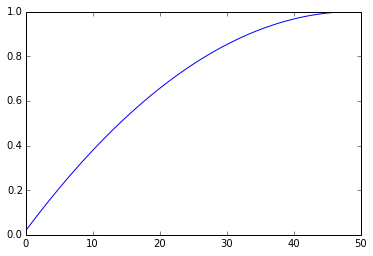

In [57]:
%matplotlib inline
n = 100
f = lambda r: r * (2*n -r ) / (n*n)

out = [f(r) for r in np.linspace(1,n)]
plt.plot(out)


In [58]:
num_cores = multiprocessing.cpu_count()
dgr_func = lambda n, d: np.ceil(n -  np.sqrt(n*n - n*n*d)) # n^2 number of measurements

for i in range(n_rows):
    dgr = dgr_range[i]
    R = dgr_func(N,dgr)
    X_mat = gen_matrix (N,R)

    for j in range(n_cols):
        obv_ratio = obv_range[j]
        result = Parallel(n_jobs=num_cores)(delayed(mat_rand_exp)(X_mat,obv_ratio, exp_id) 
                                             for exp_id in range(num_exp))
        succ_rate = 1.0* np.sum(np.asarray(result))/num_exp
        print('rank', R , 'obv_ratio', obv_ratio, 'succ_rate', succ_rate)
        mat_recv_prob[i,j] = succ_rate
        
output_data ={'xticks':obv_range, 'yticks':dgr_range, 'values':mat_recv_prob}
pickle.dump( output_data, open( "result/mat_recv_50.pkl", "wb" ) )

    

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


('rank', 3.0, 'obv_ratio', 0.0, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.020408163265306121, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.040816326530612242, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.061224489795918366, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.081632653061224483, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.1020408163265306, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.12244897959183673, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.14285714285714285, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.16326530612244897, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.18367346938775508, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.2040816326530612, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.22448979591836732, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.24489795918367346, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.26530612244897955, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio', 0.2857142857142857, 'succ_rate', 0.0)
('rank', 3.0, 'obv_ratio'

('rank', 4.0, 'obv_ratio', 0.51020408163265307, 'succ_rate', 0.42)
('rank', 4.0, 'obv_ratio', 0.53061224489795911, 'succ_rate', 0.42)
('rank', 4.0, 'obv_ratio', 0.55102040816326525, 'succ_rate', 0.64)
('rank', 4.0, 'obv_ratio', 0.5714285714285714, 'succ_rate', 0.82)
('rank', 4.0, 'obv_ratio', 0.59183673469387754, 'succ_rate', 0.86)
('rank', 4.0, 'obv_ratio', 0.61224489795918358, 'succ_rate', 0.84)
('rank', 4.0, 'obv_ratio', 0.63265306122448972, 'succ_rate', 0.88)
('rank', 4.0, 'obv_ratio', 0.65306122448979587, 'succ_rate', 0.72)
('rank', 4.0, 'obv_ratio', 0.67346938775510201, 'succ_rate', 0.62)
('rank', 4.0, 'obv_ratio', 0.69387755102040816, 'succ_rate', 0.42)
('rank', 4.0, 'obv_ratio', 0.71428571428571419, 'succ_rate', 0.62)
('rank', 4.0, 'obv_ratio', 0.73469387755102034, 'succ_rate', 0.76)
('rank', 4.0, 'obv_ratio', 0.75510204081632648, 'succ_rate', 0.86)
('rank', 4.0, 'obv_ratio', 0.77551020408163263, 'succ_rate', 0.98)
('rank', 4.0, 'obv_ratio', 0.79591836734693866, 'succ_rate', 0.

('rank', 6.0, 'obv_ratio', 0.0, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.020408163265306121, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.040816326530612242, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.061224489795918366, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.081632653061224483, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.1020408163265306, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.12244897959183673, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.14285714285714285, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.16326530612244897, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.18367346938775508, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.2040816326530612, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.22448979591836732, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.24489795918367346, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.26530612244897955, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio', 0.2857142857142857, 'succ_rate', 0.0)
('rank', 6.0, 'obv_ratio'

('rank', 7.0, 'obv_ratio', 0.53061224489795911, 'succ_rate', 0.0)
('rank', 7.0, 'obv_ratio', 0.55102040816326525, 'succ_rate', 0.0)
('rank', 7.0, 'obv_ratio', 0.5714285714285714, 'succ_rate', 0.0)
('rank', 7.0, 'obv_ratio', 0.59183673469387754, 'succ_rate', 0.0)
('rank', 7.0, 'obv_ratio', 0.61224489795918358, 'succ_rate', 0.0)
('rank', 7.0, 'obv_ratio', 0.63265306122448972, 'succ_rate', 0.0)
('rank', 7.0, 'obv_ratio', 0.65306122448979587, 'succ_rate', 0.0)
('rank', 7.0, 'obv_ratio', 0.67346938775510201, 'succ_rate', 0.0)
('rank', 7.0, 'obv_ratio', 0.69387755102040816, 'succ_rate', 0.0)
('rank', 7.0, 'obv_ratio', 0.71428571428571419, 'succ_rate', 0.0)
('rank', 7.0, 'obv_ratio', 0.73469387755102034, 'succ_rate', 0.0)
('rank', 7.0, 'obv_ratio', 0.75510204081632648, 'succ_rate', 0.0)
('rank', 7.0, 'obv_ratio', 0.77551020408163263, 'succ_rate', 0.06)
('rank', 7.0, 'obv_ratio', 0.79591836734693866, 'succ_rate', 0.14)
('rank', 7.0, 'obv_ratio', 0.81632653061224481, 'succ_rate', 0.42)
('rank',

('rank', 8.0, 'obv_ratio', 0.040816326530612242, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.061224489795918366, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.081632653061224483, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.1020408163265306, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.12244897959183673, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.14285714285714285, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.16326530612244897, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.18367346938775508, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.2040816326530612, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.22448979591836732, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.24489795918367346, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.26530612244897955, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.2857142857142857, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.30612244897959179, 'succ_rate', 0.0)
('rank', 8.0, 'obv_ratio', 0.32653061224489793, 'succ_rate', 0.0)
('rank', 8

('rank', 9.0, 'obv_ratio', 0.5714285714285714, 'succ_rate', 0.0)
('rank', 9.0, 'obv_ratio', 0.59183673469387754, 'succ_rate', 0.0)
('rank', 9.0, 'obv_ratio', 0.61224489795918358, 'succ_rate', 0.0)
('rank', 9.0, 'obv_ratio', 0.63265306122448972, 'succ_rate', 0.02)
('rank', 9.0, 'obv_ratio', 0.65306122448979587, 'succ_rate', 0.08)
('rank', 9.0, 'obv_ratio', 0.67346938775510201, 'succ_rate', 0.2)
('rank', 9.0, 'obv_ratio', 0.69387755102040816, 'succ_rate', 0.62)
('rank', 9.0, 'obv_ratio', 0.71428571428571419, 'succ_rate', 0.74)
('rank', 9.0, 'obv_ratio', 0.73469387755102034, 'succ_rate', 0.92)
('rank', 9.0, 'obv_ratio', 0.75510204081632648, 'succ_rate', 0.9)
('rank', 9.0, 'obv_ratio', 0.77551020408163263, 'succ_rate', 1.0)
('rank', 9.0, 'obv_ratio', 0.79591836734693866, 'succ_rate', 1.0)
('rank', 9.0, 'obv_ratio', 0.81632653061224481, 'succ_rate', 1.0)
('rank', 9.0, 'obv_ratio', 0.83673469387755095, 'succ_rate', 0.98)
('rank', 9.0, 'obv_ratio', 0.8571428571428571, 'succ_rate', 1.0)
('rank

('rank', 11.0, 'obv_ratio', 0.040816326530612242, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.061224489795918366, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.081632653061224483, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.1020408163265306, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.12244897959183673, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.14285714285714285, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.16326530612244897, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.18367346938775508, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.2040816326530612, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.22448979591836732, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.24489795918367346, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.26530612244897955, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.2857142857142857, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.30612244897959179, 'succ_rate', 0.0)
('rank', 11.0, 'obv_ratio', 0.32653061224489793, 'succ_rate', 

('rank', 12.0, 'obv_ratio', 0.53061224489795911, 'succ_rate', 0.0)
('rank', 12.0, 'obv_ratio', 0.55102040816326525, 'succ_rate', 0.0)
('rank', 12.0, 'obv_ratio', 0.5714285714285714, 'succ_rate', 0.0)
('rank', 12.0, 'obv_ratio', 0.59183673469387754, 'succ_rate', 0.0)
('rank', 12.0, 'obv_ratio', 0.61224489795918358, 'succ_rate', 0.0)
('rank', 12.0, 'obv_ratio', 0.63265306122448972, 'succ_rate', 0.0)
('rank', 12.0, 'obv_ratio', 0.65306122448979587, 'succ_rate', 0.0)
('rank', 12.0, 'obv_ratio', 0.67346938775510201, 'succ_rate', 0.0)
('rank', 12.0, 'obv_ratio', 0.69387755102040816, 'succ_rate', 0.0)
('rank', 12.0, 'obv_ratio', 0.71428571428571419, 'succ_rate', 0.0)
('rank', 12.0, 'obv_ratio', 0.73469387755102034, 'succ_rate', 0.02)
('rank', 12.0, 'obv_ratio', 0.75510204081632648, 'succ_rate', 0.26)
('rank', 12.0, 'obv_ratio', 0.77551020408163263, 'succ_rate', 0.54)
('rank', 12.0, 'obv_ratio', 0.79591836734693866, 'succ_rate', 0.76)
('rank', 12.0, 'obv_ratio', 0.81632653061224481, 'succ_rate

('rank', 14.0, 'obv_ratio', 0.0, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.020408163265306121, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.040816326530612242, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.061224489795918366, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.081632653061224483, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.1020408163265306, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.12244897959183673, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.14285714285714285, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.16326530612244897, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.18367346938775508, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.2040816326530612, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.22448979591836732, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.24489795918367346, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.26530612244897955, 'succ_rate', 0.0)
('rank', 14.0, 'obv_ratio', 0.2857142857142857, 'succ_rate', 0.0)
('rank', 1

('rank', 15.0, 'obv_ratio', 0.48979591836734693, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.51020408163265307, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.53061224489795911, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.55102040816326525, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.5714285714285714, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.59183673469387754, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.61224489795918358, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.63265306122448972, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.65306122448979587, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.67346938775510201, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.69387755102040816, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.71428571428571419, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.73469387755102034, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.75510204081632648, 'succ_rate', 0.0)
('rank', 15.0, 'obv_ratio', 0.77551020408163263, 'succ_rate', 0

('rank', 17.0, 'obv_ratio', 0.97959183673469385, 'succ_rate', 1.0)
('rank', 17.0, 'obv_ratio', 1.0, 'succ_rate', 1.0)
('rank', 17.0, 'obv_ratio', 0.0, 'succ_rate', 0.0)
('rank', 17.0, 'obv_ratio', 0.020408163265306121, 'succ_rate', 0.0)
('rank', 17.0, 'obv_ratio', 0.040816326530612242, 'succ_rate', 0.0)
('rank', 17.0, 'obv_ratio', 0.061224489795918366, 'succ_rate', 0.0)
('rank', 17.0, 'obv_ratio', 0.081632653061224483, 'succ_rate', 0.0)
('rank', 17.0, 'obv_ratio', 0.1020408163265306, 'succ_rate', 0.0)
('rank', 17.0, 'obv_ratio', 0.12244897959183673, 'succ_rate', 0.0)
('rank', 17.0, 'obv_ratio', 0.14285714285714285, 'succ_rate', 0.0)
('rank', 17.0, 'obv_ratio', 0.16326530612244897, 'succ_rate', 0.0)
('rank', 17.0, 'obv_ratio', 0.18367346938775508, 'succ_rate', 0.0)
('rank', 17.0, 'obv_ratio', 0.2040816326530612, 'succ_rate', 0.0)
('rank', 17.0, 'obv_ratio', 0.22448979591836732, 'succ_rate', 0.0)
('rank', 17.0, 'obv_ratio', 0.24489795918367346, 'succ_rate', 0.0)
('rank', 17.0, 'obv_ratio

('rank', 19.0, 'obv_ratio', 0.44897959183673464, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.46938775510204078, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.48979591836734693, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.51020408163265307, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.53061224489795911, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.55102040816326525, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.5714285714285714, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.59183673469387754, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.61224489795918358, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.63265306122448972, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.65306122448979587, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.67346938775510201, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.69387755102040816, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.71428571428571419, 'succ_rate', 0.0)
('rank', 19.0, 'obv_ratio', 0.73469387755102034, 'succ_rate', 0

('rank', 20.0, 'obv_ratio', 0.93877551020408156, 'succ_rate', 0.0)
('rank', 20.0, 'obv_ratio', 0.95918367346938771, 'succ_rate', 0.36)
('rank', 20.0, 'obv_ratio', 0.97959183673469385, 'succ_rate', 0.92)
('rank', 20.0, 'obv_ratio', 1.0, 'succ_rate', 1.0)
('rank', 21.0, 'obv_ratio', 0.0, 'succ_rate', 0.0)
('rank', 21.0, 'obv_ratio', 0.020408163265306121, 'succ_rate', 0.0)
('rank', 21.0, 'obv_ratio', 0.040816326530612242, 'succ_rate', 0.0)
('rank', 21.0, 'obv_ratio', 0.061224489795918366, 'succ_rate', 0.0)
('rank', 21.0, 'obv_ratio', 0.081632653061224483, 'succ_rate', 0.0)
('rank', 21.0, 'obv_ratio', 0.1020408163265306, 'succ_rate', 0.0)
('rank', 21.0, 'obv_ratio', 0.12244897959183673, 'succ_rate', 0.0)
('rank', 21.0, 'obv_ratio', 0.14285714285714285, 'succ_rate', 0.0)
('rank', 21.0, 'obv_ratio', 0.16326530612244897, 'succ_rate', 0.0)
('rank', 21.0, 'obv_ratio', 0.18367346938775508, 'succ_rate', 0.0)
('rank', 21.0, 'obv_ratio', 0.2040816326530612, 'succ_rate', 0.0)
('rank', 21.0, 'obv_rat

('rank', 23.0, 'obv_ratio', 0.4081632653061224, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.42857142857142855, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.44897959183673464, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.46938775510204078, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.48979591836734693, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.51020408163265307, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.53061224489795911, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.55102040816326525, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.5714285714285714, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.59183673469387754, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.61224489795918358, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.63265306122448972, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.65306122448979587, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.67346938775510201, 'succ_rate', 0.0)
('rank', 23.0, 'obv_ratio', 0.69387755102040816, 'succ_rate', 0.

('rank', 24.0, 'obv_ratio', 0.89795918367346927, 'succ_rate', 0.0)
('rank', 24.0, 'obv_ratio', 0.91836734693877542, 'succ_rate', 0.0)
('rank', 24.0, 'obv_ratio', 0.93877551020408156, 'succ_rate', 0.0)
('rank', 24.0, 'obv_ratio', 0.95918367346938771, 'succ_rate', 0.0)
('rank', 24.0, 'obv_ratio', 0.97959183673469385, 'succ_rate', 0.64)
('rank', 24.0, 'obv_ratio', 1.0, 'succ_rate', 1.0)
('rank', 25.0, 'obv_ratio', 0.0, 'succ_rate', 0.0)
('rank', 25.0, 'obv_ratio', 0.020408163265306121, 'succ_rate', 0.0)
('rank', 25.0, 'obv_ratio', 0.040816326530612242, 'succ_rate', 0.0)
('rank', 25.0, 'obv_ratio', 0.061224489795918366, 'succ_rate', 0.0)
('rank', 25.0, 'obv_ratio', 0.081632653061224483, 'succ_rate', 0.0)
('rank', 25.0, 'obv_ratio', 0.1020408163265306, 'succ_rate', 0.0)
('rank', 25.0, 'obv_ratio', 0.12244897959183673, 'succ_rate', 0.0)
('rank', 25.0, 'obv_ratio', 0.14285714285714285, 'succ_rate', 0.0)
('rank', 25.0, 'obv_ratio', 0.16326530612244897, 'succ_rate', 0.0)
('rank', 25.0, 'obv_rat

('rank', 27.0, 'obv_ratio', 0.36734693877551017, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.38775510204081631, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.4081632653061224, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.42857142857142855, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.44897959183673464, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.46938775510204078, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.48979591836734693, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.51020408163265307, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.53061224489795911, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.55102040816326525, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.5714285714285714, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.59183673469387754, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.61224489795918358, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.63265306122448972, 'succ_rate', 0.0)
('rank', 27.0, 'obv_ratio', 0.65306122448979587, 'succ_rate', 0.

('rank', 29.0, 'obv_ratio', 0.8571428571428571, 'succ_rate', 0.0)
('rank', 29.0, 'obv_ratio', 0.87755102040816324, 'succ_rate', 0.0)
('rank', 29.0, 'obv_ratio', 0.89795918367346927, 'succ_rate', 0.0)
('rank', 29.0, 'obv_ratio', 0.91836734693877542, 'succ_rate', 0.0)
('rank', 29.0, 'obv_ratio', 0.93877551020408156, 'succ_rate', 0.0)
('rank', 29.0, 'obv_ratio', 0.95918367346938771, 'succ_rate', 0.0)
('rank', 29.0, 'obv_ratio', 0.97959183673469385, 'succ_rate', 0.14)
('rank', 29.0, 'obv_ratio', 1.0, 'succ_rate', 1.0)
('rank', 30.0, 'obv_ratio', 0.0, 'succ_rate', 0.0)
('rank', 30.0, 'obv_ratio', 0.020408163265306121, 'succ_rate', 0.0)
('rank', 30.0, 'obv_ratio', 0.040816326530612242, 'succ_rate', 0.0)
('rank', 30.0, 'obv_ratio', 0.061224489795918366, 'succ_rate', 0.0)
('rank', 30.0, 'obv_ratio', 0.081632653061224483, 'succ_rate', 0.0)
('rank', 30.0, 'obv_ratio', 0.1020408163265306, 'succ_rate', 0.0)
('rank', 30.0, 'obv_ratio', 0.12244897959183673, 'succ_rate', 0.0)
('rank', 30.0, 'obv_rati

('rank', 33.0, 'obv_ratio', 0.32653061224489793, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.34693877551020408, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.36734693877551017, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.38775510204081631, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.4081632653061224, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.42857142857142855, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.44897959183673464, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.46938775510204078, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.48979591836734693, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.51020408163265307, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.53061224489795911, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.55102040816326525, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.5714285714285714, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.59183673469387754, 'succ_rate', 0.0)
('rank', 33.0, 'obv_ratio', 0.61224489795918358, 'succ_rate', 0.

('rank', 35.0, 'obv_ratio', 0.81632653061224481, 'succ_rate', 0.0)
('rank', 35.0, 'obv_ratio', 0.83673469387755095, 'succ_rate', 0.0)
('rank', 35.0, 'obv_ratio', 0.8571428571428571, 'succ_rate', 0.0)
('rank', 35.0, 'obv_ratio', 0.87755102040816324, 'succ_rate', 0.0)
('rank', 35.0, 'obv_ratio', 0.89795918367346927, 'succ_rate', 0.0)
('rank', 35.0, 'obv_ratio', 0.91836734693877542, 'succ_rate', 0.0)
('rank', 35.0, 'obv_ratio', 0.93877551020408156, 'succ_rate', 0.0)
('rank', 35.0, 'obv_ratio', 0.95918367346938771, 'succ_rate', 0.0)
('rank', 35.0, 'obv_ratio', 0.97959183673469385, 'succ_rate', 0.0)
('rank', 35.0, 'obv_ratio', 1.0, 'succ_rate', 1.0)
('rank', 37.0, 'obv_ratio', 0.0, 'succ_rate', 0.0)
('rank', 37.0, 'obv_ratio', 0.020408163265306121, 'succ_rate', 0.0)
('rank', 37.0, 'obv_ratio', 0.040816326530612242, 'succ_rate', 0.0)
('rank', 37.0, 'obv_ratio', 0.061224489795918366, 'succ_rate', 0.0)
('rank', 37.0, 'obv_ratio', 0.081632653061224483, 'succ_rate', 0.0)
('rank', 37.0, 'obv_rati

('rank', 41.0, 'obv_ratio', 0.2857142857142857, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.30612244897959179, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.32653061224489793, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.34693877551020408, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.36734693877551017, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.38775510204081631, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.4081632653061224, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.42857142857142855, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.44897959183673464, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.46938775510204078, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.48979591836734693, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.51020408163265307, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.53061224489795911, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.55102040816326525, 'succ_rate', 0.0)
('rank', 41.0, 'obv_ratio', 0.5714285714285714, 'succ_rate', 0.0

('rank', 50.0, 'obv_ratio', 0.77551020408163263, 'succ_rate', 0.0)
('rank', 50.0, 'obv_ratio', 0.79591836734693866, 'succ_rate', 0.0)
('rank', 50.0, 'obv_ratio', 0.81632653061224481, 'succ_rate', 0.0)
('rank', 50.0, 'obv_ratio', 0.83673469387755095, 'succ_rate', 0.0)
('rank', 50.0, 'obv_ratio', 0.8571428571428571, 'succ_rate', 0.0)
('rank', 50.0, 'obv_ratio', 0.87755102040816324, 'succ_rate', 0.0)
('rank', 50.0, 'obv_ratio', 0.89795918367346927, 'succ_rate', 0.0)
('rank', 50.0, 'obv_ratio', 0.91836734693877542, 'succ_rate', 0.0)
('rank', 50.0, 'obv_ratio', 0.93877551020408156, 'succ_rate', 0.0)
('rank', 50.0, 'obv_ratio', 0.95918367346938771, 'succ_rate', 0.0)
('rank', 50.0, 'obv_ratio', 0.97959183673469385, 'succ_rate', 0.0)
('rank', 50.0, 'obv_ratio', 1.0, 'succ_rate', 1.0)


In [59]:
print mat_recv_prob

[[ 0.    0.    0.   ...,  1.    1.    1.  ]
 [ 0.    0.    0.   ...,  1.    1.    1.  ]
 [ 0.    0.    0.   ...,  1.    0.94  1.  ]
 ..., 
 [ 0.    0.    0.   ...,  0.    0.    1.  ]
 [ 0.    0.    0.   ...,  0.    0.    1.  ]
 [ 0.    0.    0.   ...,  0.    0.    1.  ]]
